# Geographic visualization of demand clusters

This notebook visualizes the spatial distribution of demand behavior clusters across NYC taxi zones by mapping the dominant cluster for
each zone.

In [1]:
import pandas as pd

DATA_PATH = "../../data/processed/zone_hour_clusters.parquet"

In [2]:
df = pd.read_parquet(DATA_PATH)
df.head()

,zone_id,pickup_hour_ts,demand,avg_fare,avg_distance,hour,day_of_week,is_weekend,day,month,cluster
0,1,2019-01-01 10:00:00,2,61.25,16.90,10,1,0,1,1,3
1,1,2019-01-01 12:00:00,1,135.00,19.30,12,1,0,1,1,3
2,1,2019-01-01 15:00:00,1,106.00,41.28,15,1,0,1,1,3
3,1,2019-01-02 02:00:00,1,30.00,1.27,2,2,0,2,1,1
4,1,2019-01-02 03:00:00,1,15.00,12.65,3,2,0,2,1,1


### Compute dominant cluster per zone
For each taxi zone, we compute the dominant cluster based on the most frequent cluster assignment across all hours.

In [3]:
zone_cluster = (
    df
    .groupby("zone_id")["cluster"]
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
)

zone_cluster.head()

,zone_id,cluster
0,1,3
1,2,3
2,3,3
3,4,1
4,5,3


In [5]:
import geopandas as gpd

zones = gpd.read_file("../../data/geo/taxi_zones.shp")
zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


### Join clusters with geometries
We join the dominant cluster label to the taxi zone geometries.

In [6]:
zones = zones.rename(columns={"LocationID": "zone_id"})

zones_clusters = zones.merge(
    zone_cluster,
    on="zone_id",
    how="left"
)

zones_clusters.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,zone_id,borough,geometry,cluster
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",3.0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",3.0
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",3.0
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",1.0
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",3.0


In [8]:
# Verify most zones got a cluster label
zones_clusters["cluster"].isna().sum()

np.int64(2)

### Static map
We visualize the spatial distribution of dominant demand clusters.

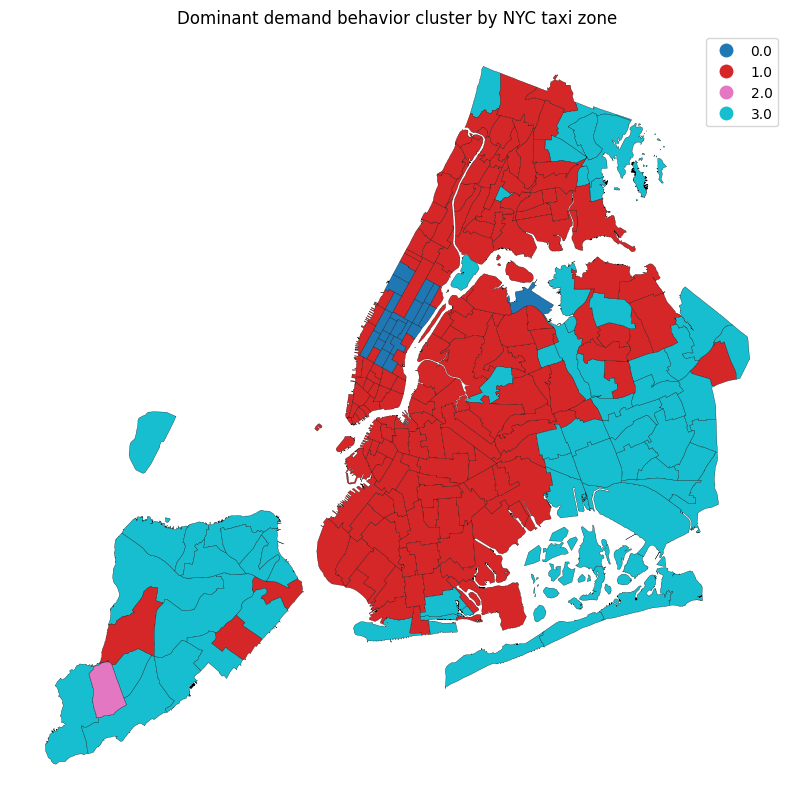

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

zones_clusters.plot(
    column="cluster",
    categorical=True,
    legend=True,
    cmap="tab10",
    edgecolor="black",
    linewidth=0.2,
    ax=ax
)

ax.set_title("Dominant demand behavior cluster by NYC taxi zone")
ax.axis("off")
plt.show()

## Interpretation

The spatial distribution of dominant demand clusters shows clear geographic structure across the city. Central and high-activity areas tend to be associated with high-intensity and late-day demand patterns, while peripheral and residential areas are dominated by low and early-day
demand profiles.

This confirms that the learned clusters capture meaningful and spatially coherent demand behavior.